# Spotify Afrobeats Recommendation System
By Afolabi Cardoso

## Exploratory Data Analysis

In this notebook, I explore the features of the Afrobeats playlist. I will see which features give the best clustering. I will also perform a time series analysis of the features to see how they change each year.

#### Import Libraries

In [424]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity
from sklearn.decomposition import PCA

from scipy import sparse
import plotly.express as px
import time

#### Import afrobeats playlist data

In [425]:
afrobeats = pd.read_csv('../data/afrobeats.csv')
afrobeats.head(2)

,track_uri,track_name,artist_name,artist_info,artist_uri,artist_popularity,artist_genre,album,track_pop,year_released,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0mDRuZmReEm6DquPLJlcEm,Oleku (feat. Brymo),Ice Prince,{'external_urls': {'spotify': 'https://open.sp...,1sSt1DqqqFLkPwfrqafVyn,54,"['afro dancehall', 'afropop', 'azontobeats', '...",Oleku (feat. Brymo),49,2010-09-21,...,0.751,162.112,audio_features,0mDRuZmReEm6DquPLJlcEm,spotify:track:0mDRuZmReEm6DquPLJlcEm,https://api.spotify.com/v1/tracks/0mDRuZmReEm6...,https://api.spotify.com/v1/audio-analysis/0mDR...,291364.0,5.0,afrobeats
1,1tvi8tv0eykhNcV1WtaIqO,Move Back,5five,{'external_urls': {'spotify': 'https://open.sp...,37zb1JQnDV9dRLatrASEj1,29,"['afro dancehall', 'azonto', 'hiplife']",Move Back,43,2011-04-08,...,0.793,125.032,audio_features,1tvi8tv0eykhNcV1WtaIqO,spotify:track:1tvi8tv0eykhNcV1WtaIqO,https://api.spotify.com/v1/tracks/1tvi8tv0eykh...,https://api.spotify.com/v1/audio-analysis/1tvi...,237107.0,4.0,afrobeats


In [426]:
afrobeats.drop(index=311, inplace=True)

#### Import fela's playlist data

In [471]:
fela = pd.read_csv('../data/fela.csv')
fela.head(2)

,track_uri,track_name,artist_name,artist_info,artist_uri,artist_popularity,artist_genre,album,track_pop,year_released,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,11GDQVqIEKAB4QKOcIVOvG,Zombie,Fela Kuti,{'external_urls': {'spotify': 'https://open.sp...,5CG9X521RDFWCuAhlo6QoR,53,"['afrobeat', 'afropop', 'funk', 'world']",Zombie,43,1977-01-01,...,0.585,131.812,audio_features,11GDQVqIEKAB4QKOcIVOvG,spotify:track:11GDQVqIEKAB4QKOcIVOvG,https://api.spotify.com/v1/tracks/11GDQVqIEKAB...,https://api.spotify.com/v1/audio-analysis/11GD...,745653,4,fela
1,6sNNtFKdCz0bnjx7IEXyl2,Expensive Shit,Fela Kuti,{'external_urls': {'spotify': 'https://open.sp...,5CG9X521RDFWCuAhlo6QoR,53,"['afrobeat', 'afropop', 'funk', 'world']",Expensive Shit,37,1975-01-01,...,0.682,122.635,audio_features,6sNNtFKdCz0bnjx7IEXyl2,spotify:track:6sNNtFKdCz0bnjx7IEXyl2,https://api.spotify.com/v1/tracks/6sNNtFKdCz0b...,https://api.spotify.com/v1/audio-analysis/6sNN...,793200,4,fela


#### Select the features we will use for EDA

In [427]:
features = ['danceability','energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']

#### Create a dataframe of the features we will use for analysis

In [428]:
df = afrobeats[features].copy()

In [429]:
df['track_name'] = afrobeats['track_name']

In [573]:
df.describe()

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters
count,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000,1873.000000
mean,0.749524,0.689779,-6.060750,0.478377,0.137061,0.278604,0.023814,0.143274,0.686705,114.506135,1.232782
std,0.118595,0.143794,2.380293,0.499666,0.101571,0.210101,0.092585,0.103644,0.194023,25.726783,1.266031
min,0.000000,0.174000,-21.272000,0.000000,0.000000,0.000294,0.000000,0.021800,0.000000,0.000000,0.000000
25%,0.679000,0.597000,-7.170000,0.000000,0.058500,0.106000,0.000000,0.086100,0.558000,100.085000,0.000000
50%,0.771000,0.703000,-5.833000,0.000000,0.100000,0.235000,0.000023,0.108000,0.712000,108.003000,1.000000
75%,0.836000,0.798000,-4.535000,1.000000,0.189000,0.418000,0.001470,0.159000,0.839000,120.022000,3.000000
max,0.978000,0.995000,0.318000,1.000000,0.550000,0.976000,0.888000,0.879000,0.981000,233.936000,3.000000


In [431]:
# fig = px.scatter_matrix(df,
#     dimensions=features, hover_name='track_name', height=2000)
# fig.show()

#### Loudness, Energy, Danceability

Loudness, energy, and danceability all have strong relationships. I will anaylse the three features below

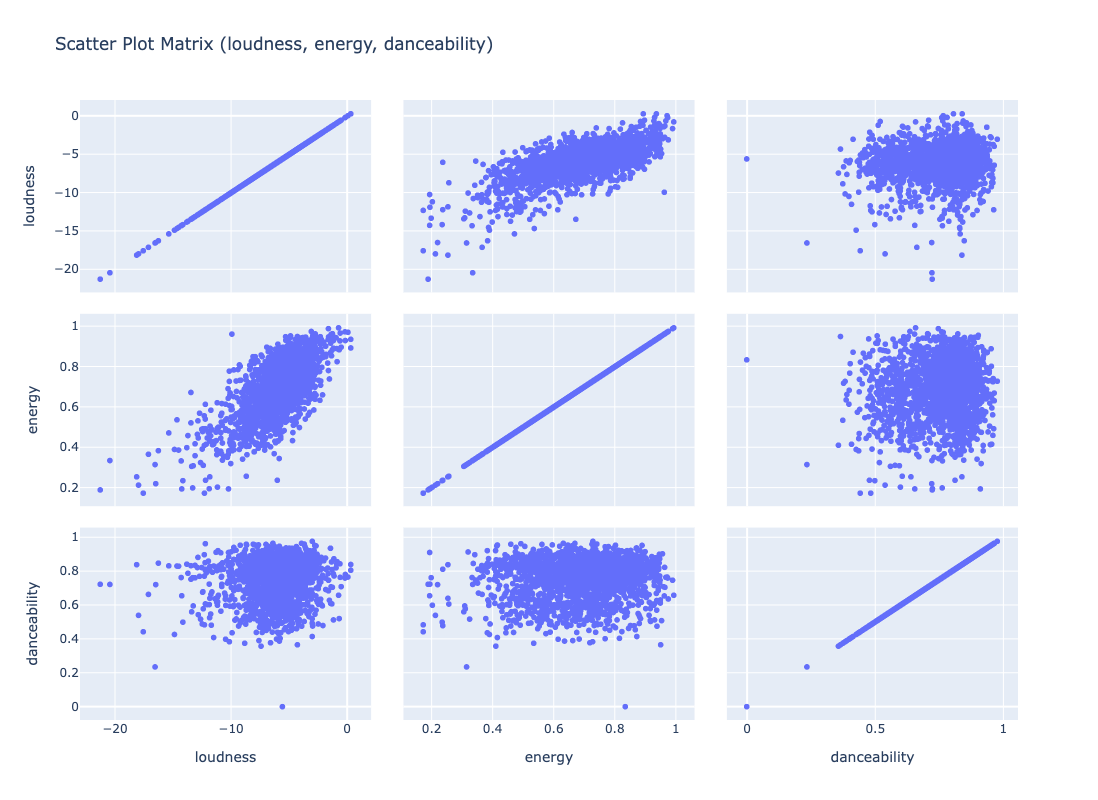

In [510]:
fig = px.scatter_matrix(df,
    dimensions=['loudness', 'energy', 'danceability'],hover_name='track_name', height=800, title = 'Scatter Plot Matrix (loudness, energy, danceability)')
fig.show();

#### Kmeans Algorithm

Using kmeans algorithm, let's create clusters of songs with loudness, energy, and danceability as features. This will help us create sub-genres based on the overall song energy, loudness and danceability

This function takes in a dataframe and the number of clusters needed and returns the labels

In [433]:
def cluster_plots(df, k):
    #scale features
    ss = StandardScaler()
    df_ss = ss.fit_transform(df) 
    
    #instantiate kmeans
    km = KMeans(n_clusters=k)
    km.fit(df_ss)
    
    #add labels to the dataframe
    labels = km.labels_
    return labels

#### Using Silhouette score and inertia, evaluate the best value for k

#### Silhoutte Score

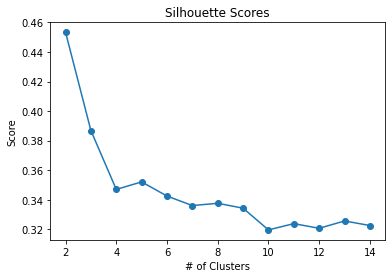

In [434]:
silhouette_list = []

for k in range(2, 15):
    #scale features
    ss = StandardScaler()
    df_ss = ss.fit_transform(df[['loudness','energy']]) 
    
    #kmeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_ss)
    silhouette_list.append(silhouette_score(df_ss, kmeans.labels_))

plt.plot(range(2, 15), silhouette_list, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Scores');

#### Inertia (Elbow plot)

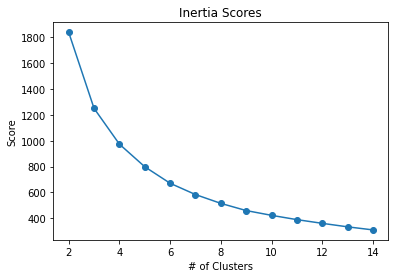

In [435]:
inertia_list = []

for k in range(2, 15):   
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_ss)
    inertia_list.append(kmeans.inertia_)
    
plt.plot(range(2, 15), inertia_list, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Inertia Scores');

k = 4, seems to be a good number for clustering

#### Generate four clusters and create a clusters column

In [436]:
df['clusters'] = cluster_plots(df[['loudness','energy']],4)

In [437]:
df['clusters'].unique()

array([0, 3, 1, 2], dtype=int32)

In [438]:
df.head()

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_name,clusters
0,0.544,0.730,-4.299,0.0,0.1440,0.344,0.000001,0.140,0.751,162.112,Oleku (feat. Brymo),0
1,0.793,0.734,-9.252,0.0,0.0981,0.323,0.000002,0.777,0.793,125.032,Move Back,0
2,0.879,0.737,-5.412,1.0,0.0421,0.525,0.005760,0.268,0.967,119.990,Pakurumo,0
3,0.697,0.841,-6.782,1.0,0.2710,0.224,0.000000,0.336,0.808,103.070,The Matter (feat. Wizkid),0
4,0.520,0.717,-3.006,0.0,0.3890,0.116,0.000000,0.249,0.704,135.550,Slow Down (feat. Wiz Kid),3


#### Using plotly to display an interactive scatter matrix

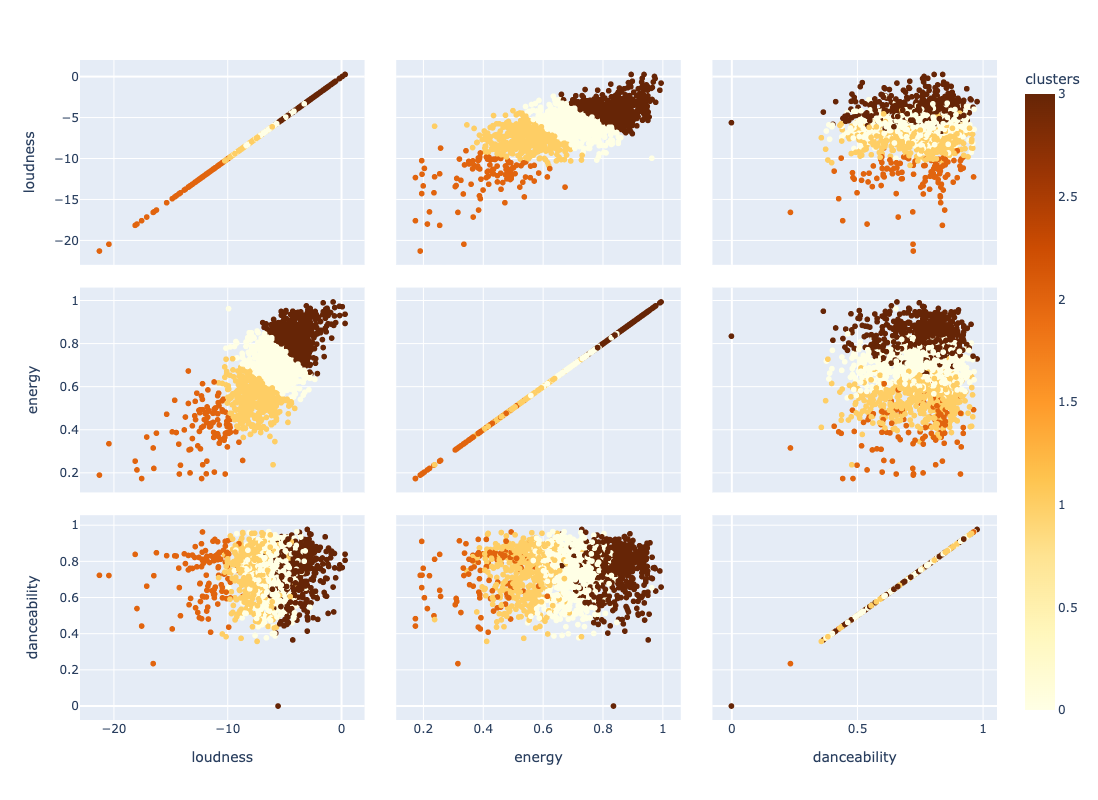

In [572]:
fig = px.scatter_matrix(df,
    dimensions=['loudness', 'energy', 'danceability'],color='clusters',color_continuous_scale='ylorbr',hover_name='track_name', height=800)
fig.show()

#### Top ten songs based on popularity

In [440]:
top_ten_songs = afrobeats.sort_values(by='track_pop',ascending=False).iloc[:10]
top_ten_songs[['track_name','artist_name']]

,track_name,artist_name
1493,Woman,Doja Cat
378,love nwantiti (ah ah ah),CKay
218,love nwantiti (feat. Dj Yo! & AX'EL) - Remix,CKay
285,One Dance,Drake
179,Peru,Fireboy DML
171,Attention,Omah Lay
279,Location (feat. Burna Boy),Dave
1400,Dégaine (feat. Damso),Aya Nakamura
393,D O D O,Tayc
254,Ameno Amapiano Remix (You Wanna Bamba),Goya Menor


In [441]:
top_ten_songs.set_index(['track_name'], inplace=True)

#### Time Series Analysis

Create a new dataframe with the track features and the year released

In [442]:
df_date = afrobeats[features]
df_date['track_name'] = afrobeats['track_name']

/var/folders/db/yz8g3qx147g7dfn7_8w2pxl80000gn/T/ipykernel_97400/2610180206.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [443]:
df_date['Date'] = afrobeats['year_released'].copy()

/var/folders/db/yz8g3qx147g7dfn7_8w2pxl80000gn/T/ipykernel_97400/2519015997.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [444]:
df_date.head(2)

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_name,Date
0,0.544,0.730,-4.299,0.0,0.1440,0.344,0.000001,0.140,0.751,162.112,Oleku (feat. Brymo),2010-09-21
1,0.793,0.734,-9.252,0.0,0.0981,0.323,0.000002,0.777,0.793,125.032,Move Back,2011-04-08


In [445]:
df_date['Date'].dtype

dtype('O')

Using the to_datetime method, I will convert the Date column to a date time object

In [446]:
df_date['Date'] = pd.to_datetime(df_date['Date'])

/var/folders/db/yz8g3qx147g7dfn7_8w2pxl80000gn/T/ipykernel_97400/583905623.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [447]:
df_date['Date'].dtype

dtype('<M8[ns]')

Set the Dale column as index and sort index

In [448]:
df_date = df_date.set_index('Date')

In [449]:
df_date.sort_index(inplace=True)

In [450]:
df_date

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_name
Date,,,,,,,,,,,
2003-01-01,0.834,0.674,-13.455,0.0,0.0721,0.12400,0.000000,0.0828,0.951,119.039,1er Gaou
2004-05-15,0.480,0.853,-2.081,0.0,0.3810,0.48300,0.000000,0.6060,0.539,79.362,African Queen
2005-10-24,0.655,0.964,-9.924,1.0,0.0511,0.06780,0.862000,0.0908,0.937,120.247,Ake Bo Je
2007-01-01,0.906,0.562,-3.355,1.0,0.1570,0.16700,0.000002,0.0794,0.928,126.011,Bum Bum
2008-01-01,0.824,0.965,-2.742,1.0,0.0409,0.24500,0.000098,0.0983,0.902,110.030,Gongo Aso
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,0.745,0.769,-5.698,0.0,0.0782,0.69800,0.000035,0.3900,0.731,103.987,Carry
2022-03-25,0.581,0.692,-6.304,1.0,0.0482,0.15200,0.000811,0.1090,0.193,102.783,Love
2022-03-27,0.861,0.588,-8.861,1.0,0.2430,0.00913,0.000000,0.0591,0.705,111.995,Sungba (feat. Burna Boy) - Remix


I will use data from 2010 to 2022

In [451]:
df_date = df_date.loc['2010':'2022']

In [452]:
df_date

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_name
Date,,,,,,,,,,,
2010-03-26,0.876,0.847,-5.642,1.0,0.2200,0.13400,0.011400,0.1150,0.759,124.950,Wengeze
2010-07-20,0.748,0.991,-1.607,1.0,0.1980,0.30600,0.000165,0.2180,0.666,116.204,Adamma
2010-08-01,0.744,0.747,-6.240,1.0,0.0549,0.40500,0.000000,0.0867,0.774,120.044,You Bad
2010-09-06,0.842,0.926,-3.830,1.0,0.1240,0.06220,0.000049,0.1360,0.963,119.998,Away
2010-09-21,0.544,0.730,-4.299,0.0,0.1440,0.34400,0.000001,0.1400,0.751,162.112,Oleku (feat. Brymo)
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,0.745,0.769,-5.698,0.0,0.0782,0.69800,0.000035,0.3900,0.731,103.987,Carry
2022-03-25,0.581,0.692,-6.304,1.0,0.0482,0.15200,0.000811,0.1090,0.193,102.783,Love
2022-03-27,0.861,0.588,-8.861,1.0,0.2430,0.00913,0.000000,0.0591,0.705,111.995,Sungba (feat. Burna Boy) - Remix


Resampling the data by year with mean as aggregate helps to create a more smoother chart

In [453]:
df_year = df_date.resample('Y').mean()

In [511]:
df_year

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
Date,,,,,,,,,,
2010-12-31,0.750800,0.848200,-4.323600,0.800000,0.148180,0.250240,0.002323,0.139140,0.782600,128.661600
2011-12-31,0.762957,0.811000,-5.304043,0.521739,0.160530,0.256672,0.055558,0.168535,0.806391,120.761261
2012-12-31,0.765316,0.849421,-4.324263,0.684211,0.131368,0.245853,0.000476,0.187389,0.846263,124.426579
2013-12-31,0.745708,0.831542,-4.077042,0.583333,0.124342,0.270775,0.005478,0.183375,0.816958,118.629417
2014-12-31,0.763038,0.821269,-4.385692,0.538462,0.117438,0.204267,0.015038,0.150154,0.806327,122.849923
2015-12-31,0.726200,0.749633,-5.044700,0.466667,0.149560,0.141077,0.014165,0.115133,0.779633,125.735100
2016-12-31,0.777265,0.736956,-4.960868,0.514706,0.116662,0.288377,0.008903,0.120293,0.765206,113.510338
2017-12-31,0.793940,0.690053,-5.380774,0.601504,0.113535,0.234237,0.009369,0.125952,0.798301,112.070173
2018-12-31,0.780058,0.690658,-5.891994,0.580645,0.112063,0.258658,0.021840,0.135519,0.752581,112.340632


#### Visualization

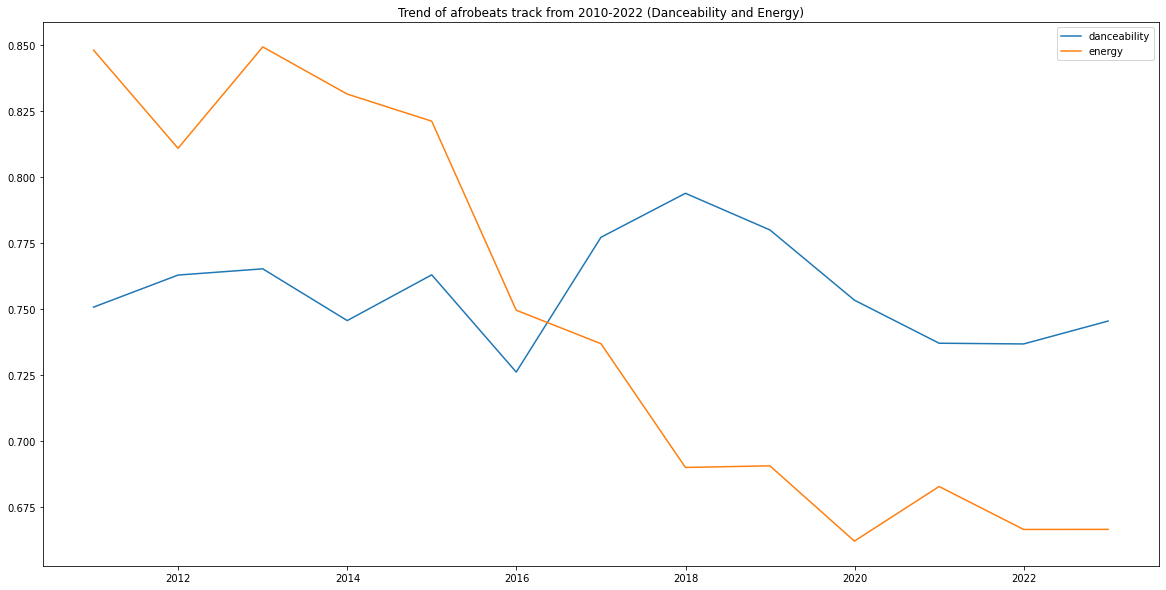

In [ ]:
plt.figure(figsize = (20,10))
plt.plot( df_year['danceability'], label='danceability')
plt.plot( df_year['energy'], label='energy')
plt.title('Trend of afrobeats track from 2010-2022 (Danceability and Energy)')
plt.legend();

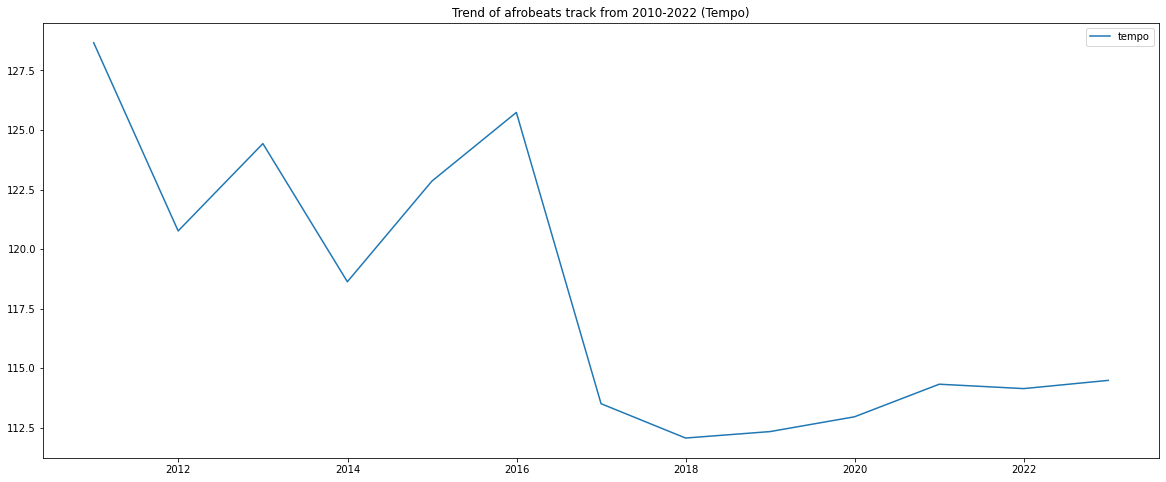

In [456]:
plt.figure(figsize = (20,8))
plt.plot( df_year['tempo'], label='tempo')
plt.title('Trend of afrobeats track from 2010-2022 (Tempo)')
plt.legend();

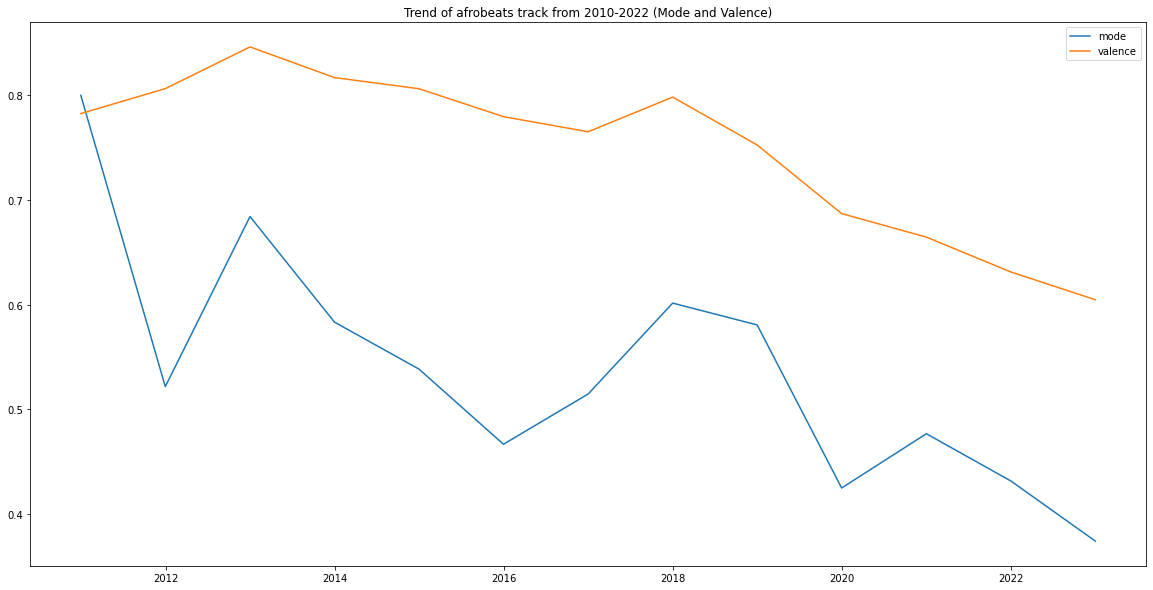

In [457]:
plt.figure(figsize = (20,10))
plt.plot( df_year['mode'], label='mode')
plt.plot( df_year['valence'], label='valence')
plt.title('Trend of afrobeats track from 2010-2022 (Mode and Valence)')
plt.legend();

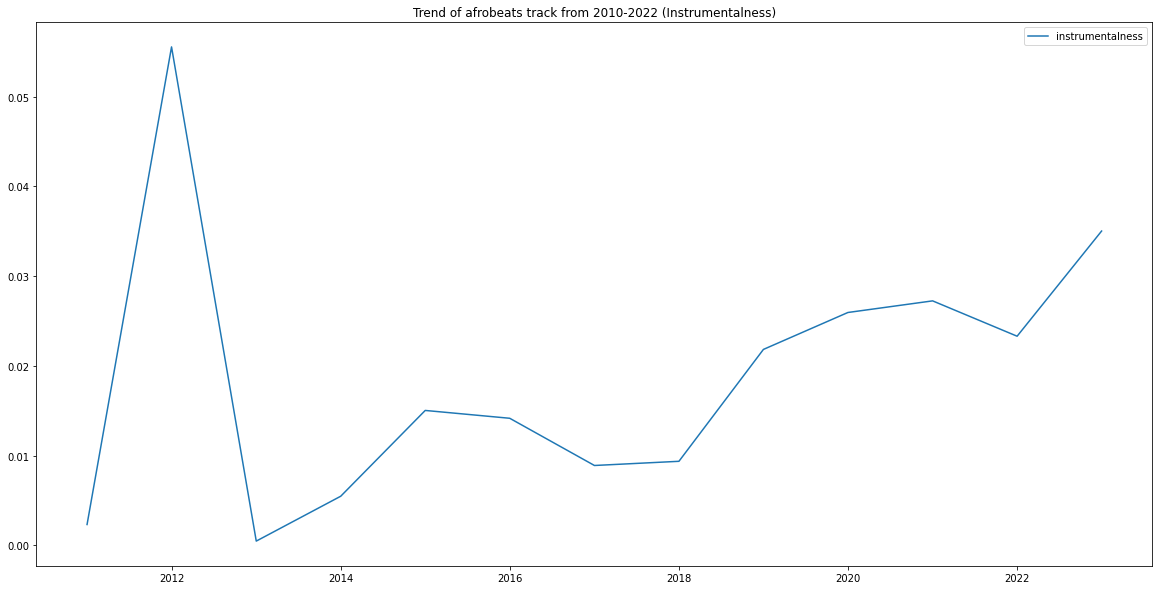

In [458]:
plt.figure(figsize = (20,10))
plt.plot( df_year['instrumentalness'], label='instrumentalness')
plt.title('Trend of afrobeats track from 2010-2022 (Instrumentalness)')
plt.legend();

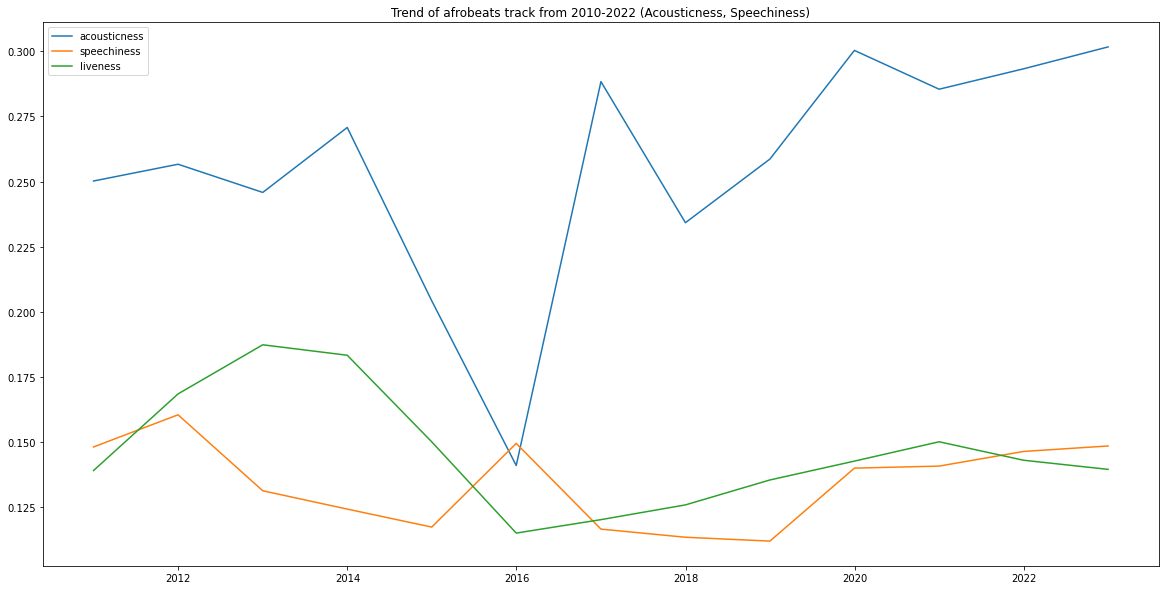

In [486]:
plt.figure(figsize = (20,10))
plt.plot( df_year['acousticness'], label='acousticness')
plt.plot( df_year['speechiness'], label='speechiness')
plt.plot( df_year['liveness'], label='liveness')
plt.title('Trend of afrobeats track from 2010-2022 (Acousticness, Speechiness)')
plt.legend();

#### Let's compare the sounds of modern afrobeats with Fela's sound

In [502]:
df_fela = fela[features].copy()

In [504]:
df_fela['instrumentalness'].mean()

0.10702085714285714

In [505]:
df_year['instrumentalness'].mean()

0.01882339142785185

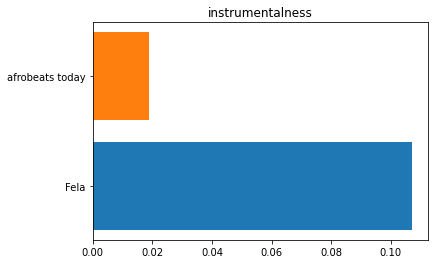

In [499]:
plt.barh('Fela', df_fela['instrumentalness'].mean())
plt.barh('afrobeats today', df_year['instrumentalness'].mean())
plt.title('instrumentalness')
plt.show();

The chart above shows the difference in amount of instuments between Fela's music and Afrobeats today. 

In [507]:
df_fela['speechiness'].mean()

0.08302857142857144

In [508]:
df_year['speechiness'].mean()

0.13458461001976368

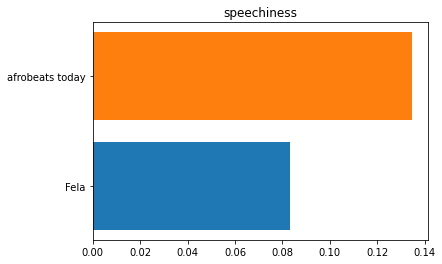

In [501]:
plt.barh('Fela', df_fela['speechiness'].mean())
plt.barh('afrobeats today', df_year['speechiness'].mean())
plt.title('speechiness')
plt.show();

As the amount of instrumentals dropped, speechiness increased. Afrobeats artist today tend to have more lyrics in their songs

#### Comparnig Afrobeats features with features from other Genres

#### Import the other genre's

In [514]:
country = pd.read_csv('../data/country.csv')

In [515]:
hiphop = pd.read_csv('../data/hiphop.csv')

In [516]:
rnb = pd.read_csv('../data/rnb.csv')

In [517]:
metal = pd.read_csv('../data/heavymetal.csv')

In [518]:
jazz = pd.read_csv('../data/jazz.csv')

In [550]:
rock = pd.read_csv('../data/rock.csv')

#### Instrumentslness

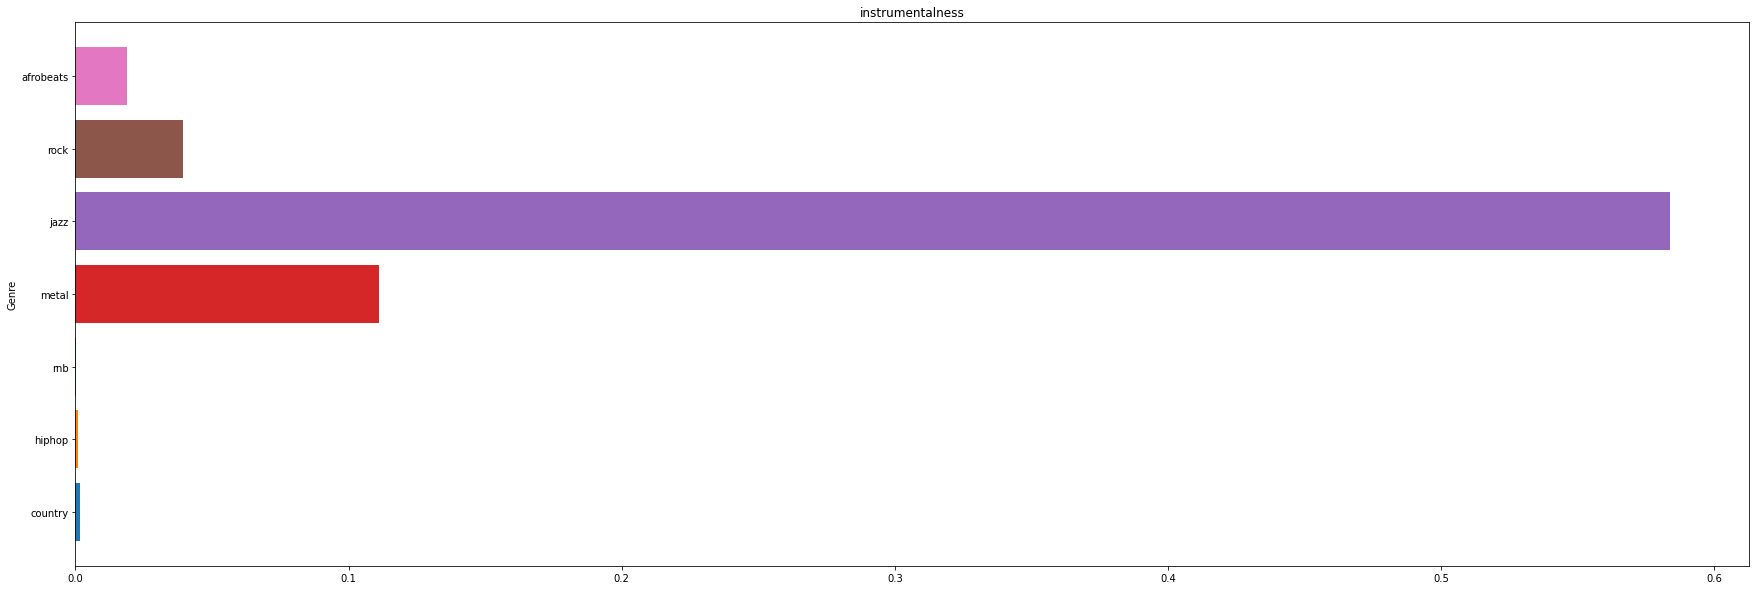

In [551]:
plt.figure(figsize = (30,10))
plt.barh('country', country['instrumentalness'].mean())
plt.barh('hiphop', hiphop['instrumentalness'].mean())
plt.barh('rnb', rnb['instrumentalness'].mean())
plt.barh('metal', metal['instrumentalness'].mean())
plt.barh('jazz', jazz['instrumentalness'].mean())
plt.barh('rock', rock['instrumentalness'].mean())
plt.barh('afrobeats', df_year['instrumentalness'].mean())
plt.title('instrumentalness')
plt.ylabel('Genre')
plt.show();

#### Danceability

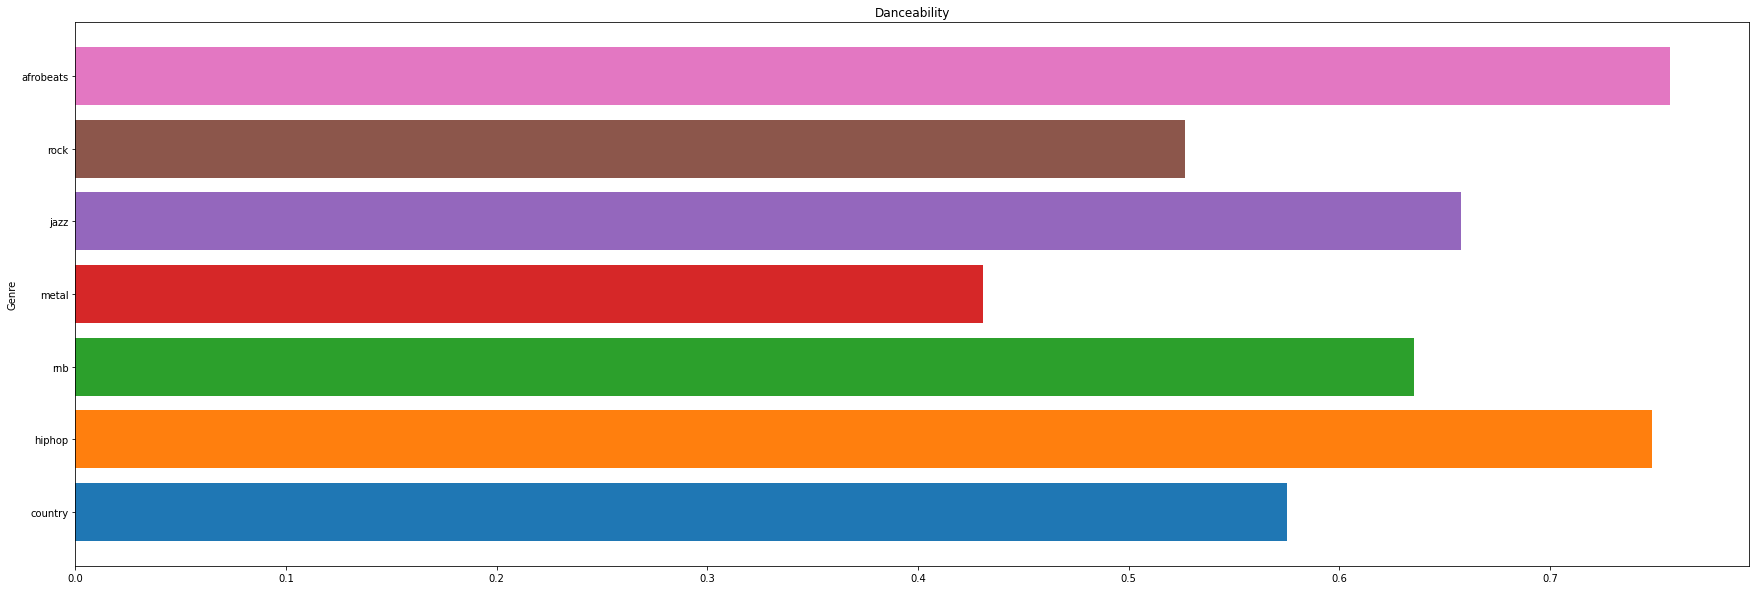

In [552]:
plt.figure(figsize = (30,10))
plt.barh('country', country['danceability'].mean())
plt.barh('hiphop', hiphop['danceability'].mean())
plt.barh('rnb', rnb['danceability'].mean())
plt.barh('metal', metal['danceability'].mean())
plt.barh('jazz', jazz['danceability'].mean())
plt.barh('rock', rock['danceability'].mean())
plt.barh('afrobeats', df_year['danceability'].mean())
plt.title('Danceability')
plt.ylabel('Genre')
plt.show();

#### Energy

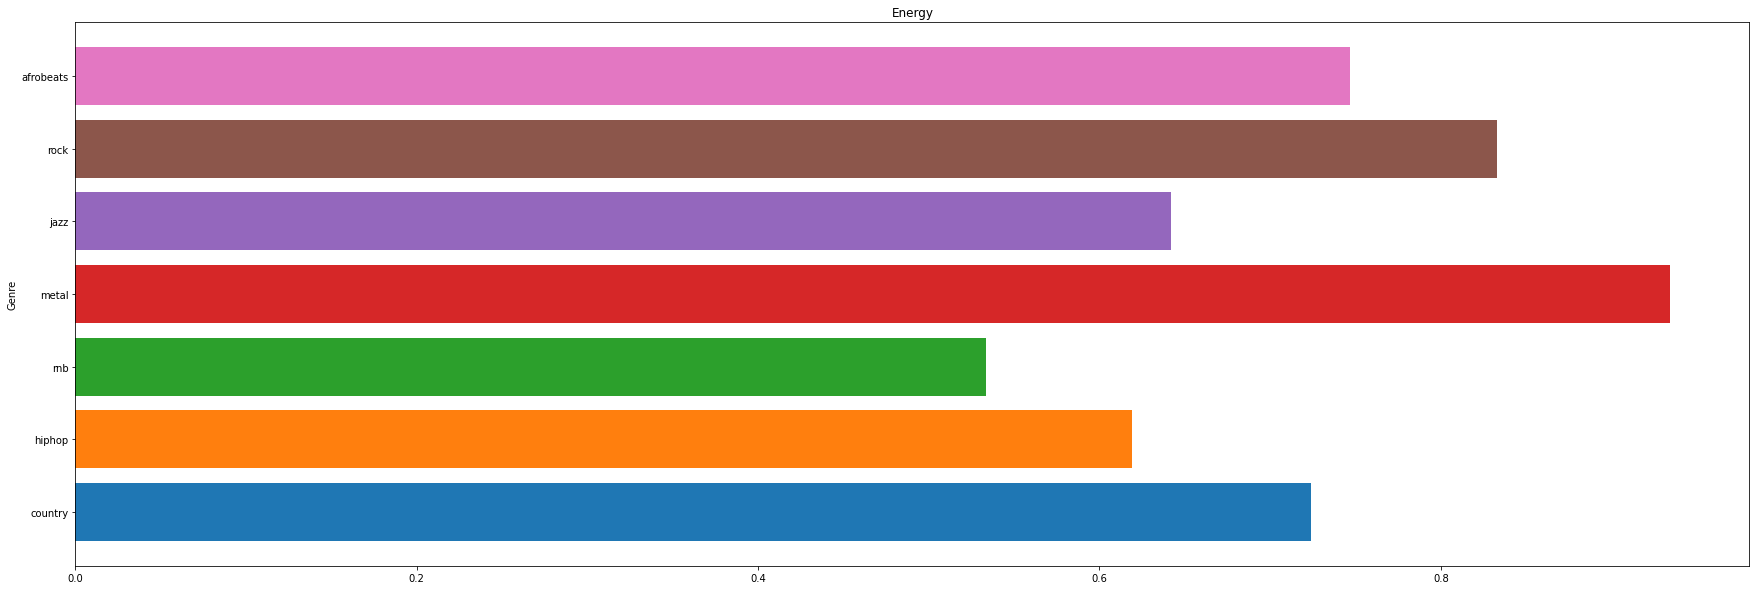

In [553]:
plt.figure(figsize = (30,10))
plt.barh('country', country['energy'].mean())
plt.barh('hiphop', hiphop['energy'].mean())
plt.barh('rnb', rnb['energy'].mean())
plt.barh('metal', metal['energy'].mean())
plt.barh('jazz', jazz['energy'].mean())
plt.barh('rock', rock['energy'].mean())
plt.barh('afrobeats', df_year['energy'].mean())
plt.title('Energy')
plt.ylabel('Genre')
plt.show();

In [562]:
afrobeats[features].describe().loc['mean']

danceability          0.749524
energy                0.689779
loudness             -6.060750
mode                  0.478377
speechiness           0.137061
acousticness          0.278604
instrumentalness      0.023814
liveness              0.143274
valence               0.686705
tempo               114.506135
Name: mean, dtype: float64

In [563]:
country[features].describe().loc['mean']

danceability          0.574940
energy                0.723695
loudness             -5.488635
mode                  0.920000
speechiness           0.041432
acousticness          0.178281
instrumentalness      0.001489
liveness              0.163033
valence               0.556817
tempo               125.559935
Name: mean, dtype: float64

In [564]:
rnb[features].describe().loc['mean']

danceability          0.635500
energy                0.533500
loudness             -7.495500
mode                  0.420000
speechiness           0.118878
acousticness          0.186682
instrumentalness      0.000098
liveness              0.166336
valence               0.341742
tempo               112.508640
Name: mean, dtype: float64

In [565]:
rock[features].describe().loc['mean']

danceability          0.526820
energy                0.832780
loudness             -4.793900
mode                  0.660000
speechiness           0.069990
acousticness          0.019581
instrumentalness      0.039195
liveness              0.188856
valence               0.489220
tempo               127.343040
Name: mean, dtype: float64

In [566]:
metal[features].describe().loc['mean']

danceability          0.430864
energy                0.934164
loudness             -5.329243
mode                  0.564286
speechiness           0.084992
acousticness          0.001753
instrumentalness      0.111309
liveness              0.212837
valence               0.340826
tempo               135.566093
Name: mean, dtype: float64

In [567]:
jazz[features].describe().loc['mean']

danceability          0.657860
energy                0.641760
loudness             -8.405800
mode                  0.400000
speechiness           0.037280
acousticness          0.468816
instrumentalness      0.583699
liveness              0.150764
valence               0.634800
tempo               106.463780
Name: mean, dtype: float64

In [568]:
hiphop[features].describe().loc['mean']

danceability          0.748210
energy                0.618900
loudness             -6.221940
mode                  0.530000
speechiness           0.221458
acousticness          0.103192
instrumentalness      0.001079
liveness              0.200847
valence               0.413891
tempo               128.090750
Name: mean, dtype: float64

#### In the next notebook, I will be using the playlists gotten from my classmates to create a recommendation system.